# 02: 次元削減 - 非線形マニフォールド学習

このノートブックでは、前回のPCAやLDAのような線形手法では捉えきれない、データの<b>非線形な構造（マニフォールド）</b>を学習するための次元削減手法について学びます。
実世界の多くのデータ（例：顔画像、手書き文字）は、高次元空間内において、より低い次元の曲がった多様体（マニフォールド）上に分布していると考えられます。マニフォールド学習は、この内在的な構造を保ったまま、データを低次元空間に展開（embedding）することを目指します。

ここでは、代表的な3つのマニフォールド学習手法、**Isomap**、**Locally Linear Embedding (LLE)**、そして可視化で絶大な効果を発揮する**t-SNE**を取り上げます。

**参考論文:**
*   (Isomap) Tenenbaum, J. B., de Silva, V., & Langford, J. C. (2000). A global geometric framework for nonlinear dimensionality reduction. *Science*, 290(5500), 2319-2323.
*   (LLE) Roweis, S. T., & Saul, L. K. (2000). Nonlinear dimensionality reduction by locally linear embedding. *Science*, 290(5500), 2323-2326.
*   (t-SNE) van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. *Journal of Machine Learning Research*, 9(11).

**このノートブックで学ぶこと:**
1.  マニフォールド学習の基本概念と、なぜ非線形な次元削減が必要か。
2.  Isomapの理論：測地線距離を近似し、MDSで埋め込む。
3.  LLEの理論：局所的な線形関係を保持したまま、大域的な座標系を再構成する。
4.  t-SNEの理論：高次元空間と低次元空間でのデータ点間の類似度（確率分布）を近づける。
5.  各アルゴリズムのNumPyによるスクラッチ実装。
6.  「スイスロール」データに対する各手法の適用と結果の比較。

**前提知識:**
*   PCAと多次元尺度法（MDS）の基本概念。
*   グラフ理論の基礎（特に最短経路問題、Dijkstra法やFloyd-Warshall法）。
*   線形代数の基礎（固有値・固有ベクトル）。
*   NumPyによるベクトル・行列演算。

## 1. 必要なライブラリのインポート

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import floyd_warshall
from numpy.linalg import eigh
from scipy.linalg import eigh as scipy_eigh

## 2. マニフォールド学習の基本アイデア

PCAのような線形手法は、データ点間の**ユークリッド距離**を基準にしています。しかし、データが下の図のように曲がった多様体（マニフォールド）上にある場合、ユークリッド距離（図の点線）は、マニフォールド上の真の距離（**測地線距離**、図の実線）を正しく反映しません。

<center><img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_compare_methods_001.png" width="400"></center>
<center><small>出典: scikit-learn documentation</small></center>

マニフォールド学習の目標は、この測地線距離のような、データの**内在的な幾何学的構造**を保ったまま、データを低次元空間に展開することです。

**ポイント:**
- **ユークリッド距離**: 高次元空間での直線距離（点線で示される）
- **測地線距離**: マニフォールド表面に沿った実際の距離（実線で示される）

### 2.1 データの準備

マニフォールド学習の性能を比較するために、「スイスロール」データを生成します。

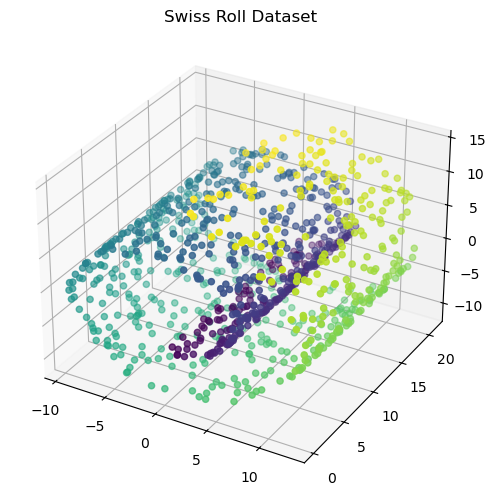

In [89]:
# スイスロールデータの生成
X, color = make_swiss_roll(n_samples=1000, random_state=42)

# 3Dでプロット
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.viridis)
ax.set_title("Swiss Roll Dataset")
plt.show()

## 3. Isomap (Isometric Mapping)

Isomapは、マニフォールド上の**測地線距離**を保持することを目指す手法です。

### 3.1 Isomapのアルゴリズム

1.  **近傍グラフの構築**: 各データ点について、最も近い $k$ 個の点（k-nearest neighbors）を見つけ出し、それらの点との間に辺を張ったグラフを構築します。辺の重みは、点間のユークリッド距離とします。

2.  **最短経路距離の計算**: 構築したグラフ上で、全ての点ペア間の**最短経路距離**を計算します。これには、Dijkstra法やFloyd-Warshall法などのアルゴリズムが用いられます。このグラフ上の最短経路距離が、マニフォールド上の測地線距離の良い近似となります。

3.  **多次元尺度法 (MDS) の適用**: ステップ2で得られた全点ペア間の最短経路距離行列を基に、古典的MDSを適用します。MDSは、与えられた距離行列を最もよく再現するような低次元の座標系を見つけ出します。


In [90]:
class Isomap:
    def __init__(self, n_components=2, n_neighbors=10):
        self.n_components = n_components # 主成分の数
        self.n_neighbors = n_neighbors # 近傍の数
    
    def fit_transform(self, x):
        # 近傍グラフの構築
        knn = NearestNeighbors(n_neighbors=self.n_neighbors)
        knn.fit(x)
        # 距離行列を取得
        dist_matrix = knn.kneighbors_graph(x, mode='distance')

        # 最短経路距離（Floyd-Warshall法）
        geodesic_dist_matrix = floyd_warshall(csgraph=dist_matrix, directed=False)

        # MDSの適用
        # 中心化
        n_samples = x.shape[0]
        J = np.eye(n_samples) - np.ones((n_samples, n_samples)) / n_samples
        # グラム行列G = -0.5 * J * D^2 * J
        G = -0.5 * J @ (geodesic_dist_matrix ** 2) @ J

        # グラム行列の固有値分解
        eigenvalues, eigenvectors = eigh(G)

        # 固有値の降順にソート
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # 埋め込み座標を計算 Y = V_k * sqrt(Lambda_k)
        Y = eigenvectors[:, :self.n_components] * np.sqrt(eigenvalues[:self.n_components])

        return Y

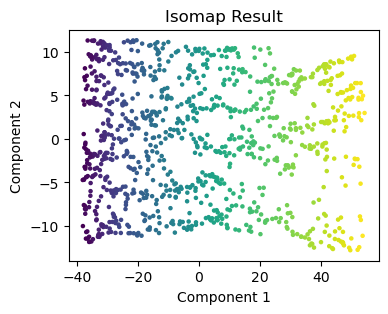

In [91]:
# Isomapを実行
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X)

# 結果をプロット
plt.figure(figsize=(4, 3))
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=color, cmap=plt.cm.viridis, s=5)
plt.title("Isomap Result")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## 4. Locally Linear Embedding (LLE)

LLEは、Isomapとは異なるアプローチを取ります。測地線距離を保持する代わりに、「**各データ点は、その近傍の点たちの線形結合でうまく再構成できる**」という仮定に基づきます。この局所的な線形関係を保持したまま、低次元空間に埋め込むことを目指します。

### 4.1 LLEのアルゴリズム

1.  **近傍点の選択**: 各データ点 $\boldsymbol{x}_i$ について、その近傍点（k-NN）を見つけます。

2.  **再構成重みの計算**: 各データ点 $\boldsymbol{x}_i$ を、その近傍点 $\{\boldsymbol{x}_j\}$ の線形結合で再構成する際の最適な重み $W_{ij}$ を求めます。これは、以下のコスト関数を最小化することで得られます（ただし、$\sum_j W_{ij} = 1$）。
    $$ \min_W \sum_i || \boldsymbol{x}_i - \sum_{j} W_{ij} \boldsymbol{x}_j ||^2 $$
    この重み行列 $W$ は、高次元空間における各点の「局所的な幾何学的構造」を捉えています。

3.  **低次元埋め込みの計算**: ステップ2で計算した重み $W$ を**固定**したまま、この重みを使って低次元空間での座標 $\boldsymbol{y}_i$ を再構成した際のエラーが最小になるような $\{\boldsymbol{y}_i\}$ を求めます。
    $$ \min_Y \sum_i || \boldsymbol{y}_i - \sum_{j} W_{ij} \boldsymbol{y}_j ||^2 $$
    この問題は、ある行列の固有値問題に帰着し、その**最も小さい固有値に対応する固有ベクトルたち**（ただし自明な解である全ての要素が1のベクトルは除く）が、求める低次元座標 $\boldsymbol{y}_i$ となります。

### 4.2 LLEのスクラッチ実装

In [92]:
class LLE:
    def __init__(self, n_components=2, n_neighbors=10):
        self.n_components = n_components # 主成分の数
        self.n_neighbors = n_neighbors # 近傍の数

    def fit_transform(self, x):
        n_samples, n_features = x.shape

        # 近傍グラフの構築
        knn = NearestNeighbors(n_neighbors=self.n_neighbors + 1) # +1は自身を含むため
        knn.fit(x)

        # 距離とインデックスを取得（自身を含む）
        distances, indices = knn.kneighbors(x)
        indices = indices[:, 1:] # 自身を除外

        # 重み行列Wの計算
        W = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            neighbors_idx = indices[i]
            neighbors = x[neighbors_idx] - x[i] # 中心化
            
            # グラム行列の計算 G = (X_i - X_j) * (X_i - X_j).T
            G = neighbors @ neighbors.T
            # Gが特異行列に近い場合，正則化
            G += 1e-3 * np.eye(self.n_neighbors)
            # 重みを計算 w = G^-1 * 1
            w = np.linalg.solve(G, np.ones(self.n_neighbors))
            # 正規化 sum(w) = 1
            W[i, neighbors_idx] = w / np.sum(w)

        # 低次元埋め込みの計算
        # コスト行列 M = (I - W)^T * (I - W)
        I = np.eye(n_samples)
        M = (I - W).T @ (I - W)

        # 固有値分解
        # 最も小さい固有値は0で，固有ベクトルは定数ベクトル
        # 2番目からd+1番目までの固有ベクトルが埋め込み座標
        eigenvalues, eigenvectors = scipy_eigh(M, eigvals=(1, self.n_components))

        return eigenvectors

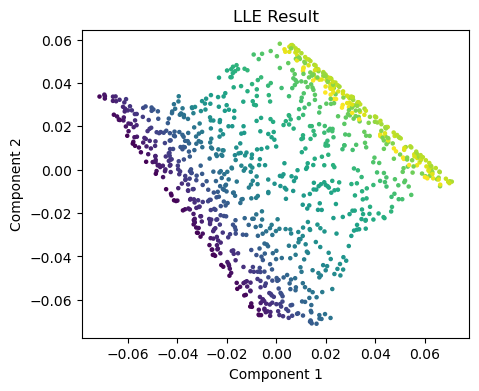

In [93]:
# LLEを実行
lle = LLE(n_components=2, n_neighbors=12)
X_lle = lle.fit_transform(X)

# 結果をプロット
plt.figure(figsize=(5, 4))
plt.scatter(X_lle[:, 0], X_lle[:, 1], c=color, cmap=plt.cm.viridis, s=5)
plt.title("LLE Result")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## 5. t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNEは、特に**データの可視化**に特化した強力なマニフォールド学習手法です。その目的は、高次元空間で「近くにある」データ点が、低次元空間でも「近くに」配置され、逆に「遠くにある」データ点が「遠くに」配置されるようにすることです。

### 5.1 t-SNEの理論

1.  **高次元空間での類似度の定義**:
    データ点 $\boldsymbol{x}_i$ が、他の点 $\boldsymbol{x}_j$ を近傍点として選ぶ条件付き確率 $p_{j|i}$ を、ガウス分布を用いて定義します。
    $$ p_{j|i} = \frac{\exp(-||\boldsymbol{x}_i - \boldsymbol{x}_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||\boldsymbol{x}_i - \boldsymbol{x}_k||^2 / 2\sigma_i^2)} $$
    ここで、$\sigma_i$ は各点ごとに異なるガウス分布の分散で、<b>パープレキシティ（Perplexity）</b>というハイパーパラメータに基づいて自動的に調整されます。
    その後、同時確率 $p_{ij} = (p_{j|i} + p_{i|j}) / 2N$ として対称化します。

2.  **低次元空間での類似度の定義**:
    低次元空間に埋め込まれた点 $\boldsymbol{y}_i, \boldsymbol{y}_j$ 間の類似度 $q_{ij}$ は、裾の重い**スチューデントのt分布**（自由度1）を用いて定義します。
    $$ q_{ij} = \frac{(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||\boldsymbol{y}_k - \boldsymbol{y}_l||^2)^{-1}} $$
    t分布を使うことで、中程度の距離の点を低次元空間でより遠くに配置でき、「クラウディング問題」（点が中心に密集してしまう問題）を緩和します。

3.  **損失関数の最小化**:
    2つの確率分布 $P=\{p_{ij}\}$ と $Q=\{q_{ij}\}$ の間の**KLダイバージェンス**を損失関数とし、これを勾配降下法で最小化することで、最適な低次元座標 $\{\boldsymbol{y}_i\}$ を見つけます。
    $$ L = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}} $$

### 5.2 t-SNEのスクラッチ実装（簡易版）

t-SNEの完全な実装（特にパープレキシティに基づく$\sigma_i$の探索）は複雑なため、ここでは中心的なアイデアである「類似度行列の計算」と「勾配降下による座標の最適化」を示す簡易版を実装します。

In [94]:
def get_pairwise_affinities(X, perplexity=30.0):
    """高次元空間での類似度(同時確率P)を計算する"""
    n_samples = X.shape[0]
    
    # 全ペア間の距離の二乗を計算
    dist_sq = np.sum(np.square(X[:, np.newaxis, :] - X[np.newaxis, :, :]), axis=-1)
    
    # この簡易版では、σを固定値とする
    # (本来はパープレキシティに基づいて各点ごとにσを探索する)
    sigma_sq = 1.0 
    
    # 条件付き確率 P_j|i
    P_cond = np.exp(-dist_sq / (2 * sigma_sq))
    np.fill_diagonal(P_cond, 0.)
    P_cond /= np.sum(P_cond, axis=1, keepdims=True)
    
    # 同時確率 P_ij
    P = (P_cond + P_cond.T) / (2 * n_samples)
    return P

def tsne_grad(P, Y):
    """t-SNEの勾配を計算する"""
    n_samples = Y.shape[0]
    
    # 低次元空間での類似度Qを計算
    dist_sq_low = np.sum(np.square(Y[:, np.newaxis, :] - Y[np.newaxis, :, :]), axis=-1)
    inv_dist = 1. / (1. + dist_sq_low)
    np.fill_diagonal(inv_dist, 0.)
    Q = inv_dist / np.sum(inv_dist)
    
    # 勾配の計算
    grad = np.zeros_like(Y)
    PQ_diff = P - Q
    for i in range(n_samples):
        grad[i, :] = 4 * np.sum(PQ_diff[:, i, np.newaxis] * (Y[i, :] - Y) * inv_dist[:, i, np.newaxis], axis=0)
    
    return grad, Q

def tsne(X, n_components=2, perplexity=30.0, n_iter=1000, lr=100.0):
    """t-SNEを実行する"""
    n_samples = X.shape[0]
    
    # 高次元空間での類似度Pを計算
    P = get_pairwise_affinities(X, perplexity)
    
    # 低次元座標Yをランダムに初期化
    Y = np.random.randn(n_samples, n_components) * 0.0001
    
    # 勾配降下法による最適化
    for i in range(n_iter):
        grad, _ = tsne_grad(P, Y)
        Y = Y - lr * grad
        
        # 定期的にプロット（可視化用）
        if i % (n_iter // 10) == 0:
            print(f"Iteration {i}")
    
    return Y

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


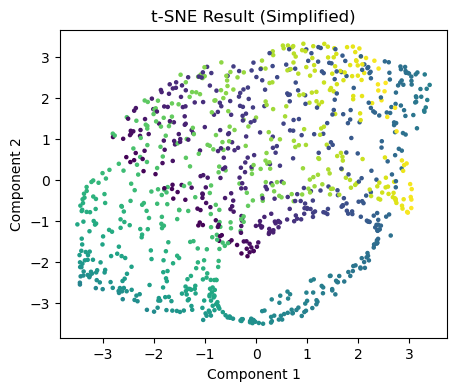

In [95]:
# t-SNEを実行 (簡易版のため、パラメータ調整がシビア)
# スイスロールデータはσのスケールが大きいため、標準化してから適用
X_scaled = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_tsne = tsne(X_scaled, n_components=2, lr=100.0, n_iter=1000, perplexity=15.0)

# 結果をプロット
plt.figure(figsize=(5, 4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap=plt.cm.viridis, s=5)
plt.title("t-SNE Result (Simplified)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## 6. まとめと考察

このノートブックでは、非線形なデータ構造を捉えるための3つの代表的なマニフォールド学習手法、Isomap、LLE、t-SNEについて学びました。

*   **Isomap**は、データ点間の**測地線距離**を保持することで、大域的なマニフォールドの構造を捉えようとします。スイスロールの例では、見事に巻きをほどいて2次元平面に展開できました。

*   **LLE**は、各点の**局所的な線形関係**を保持することに焦点を当てます。Isomapと同様に、非線形構造をうまく捉えることができますが、近傍点の選び方（$k$の値）に敏感な場合があります。

*   **t-SNE**は、高次元と低次元での**データ点間の類似度の確率分布**を一致させることを目指します。特に**可視化**に優れており、異なるクラスタを明確に分離し、クラスタ内の微細な構造も表現する能力があります。ただし、大域的な距離関係は必ずしも保持されず、クラスタ間の距離やサイズを文字通りに解釈すべきではありません。

これらの手法は、PCAでは見過ごされてしまうようなデータの複雑な内在的構造を明らかにするための強力なツールです。データの可視化や、非線形性を考慮した特徴量抽出など、様々な場面で応用されます。